In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cirq import (
    CXPowGate,
    DepolarizingChannel,
    LineQubit,
    Circuit,
)
from mitiq import Executor, Observable, PauliString
from mitiq.interface.mitiq_cirq import compute_density_matrix
from mitiq.cdr import generate_training_circuits
from mitiq.cdr._testing import random_x_z_cnot_circuit
from mitiq.pec import execute_with_pec
from mitiq.pec.representations.depolarizing import (
    represent_operation_with_local_depolarizing_noise,
)
from mitiq.pec.representations.learning import (
    depolarizing_noise_loss_function,
    learn_depolarizing_noise_parameter,
)

In [2]:
circuit = random_x_z_cnot_circuit(
    LineQubit.range(2), n_moments=5, random_state=np.random.RandomState(1)
)
print(circuit)

0: ───Rx(1.14π)───Rz(0)───X───Rx(1.71π)───────────────
                          │
1: ───────────────────────@───────────────Rx(1.14π)───


In [3]:
def ideal_execute(circ: Circuit) -> np.ndarray:
    # For large circuits, this should be replaced by a near-Clifford simulator.
    return compute_density_matrix(circ, noise_level=(0.0,))


ideal_executor = Executor(ideal_execute)

In [4]:
CNOT_ops = list(circuit.findall_operations_with_gate_type(CXPowGate))

operations_to_learn = [Circuit(op[1]) for op in CNOT_ops]

epsilon = 0.05

def noisy_execute(circ: Circuit) -> np.ndarray:
    noisy_circ = circ.copy()
    insertions = []
    for op in CNOT_ops:
        index = op[0] + 1
        qubits = op[1].qubits
        for q in qubits:
            insertions.append((index, DepolarizingChannel(epsilon)(q)))
    noisy_circ.batch_insert(insertions)

    return ideal_execute(noisy_circ)


noisy_executor = Executor(noisy_execute)

In [5]:
pec_kwargs = {"num_samples": 500, "random_state": 1}
observable = Observable(PauliString("XZ"), PauliString("YY"))

import warnings
# suppress warnings about missing representations
# this example only simulates noise on CNOT
warnings.simplefilter("ignore", UserWarning)

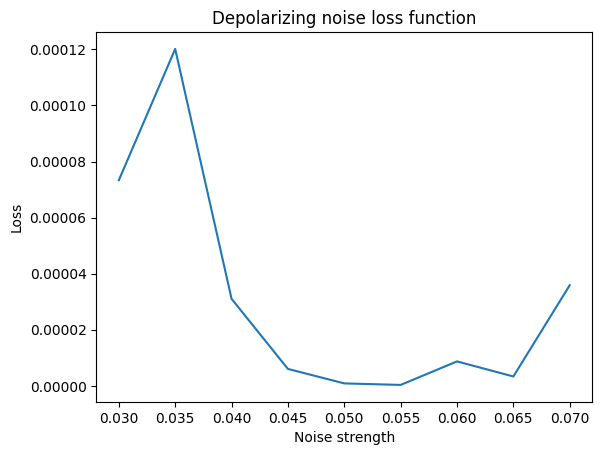

In [6]:
training_circuits = generate_training_circuits(
    circuit=circuit,
    num_training_circuits=5,
    fraction_non_clifford=0.2,
    random_state=np.random.RandomState(1),
)

ideal_values = np.array(ideal_executor.evaluate(training_circuits, observable))

epsilons = np.linspace(0.03, 0.07, 9)

loss = [
    depolarizing_noise_loss_function(
        [eps],
        operations_to_learn,
        training_circuits,
        ideal_values,
        noisy_executor,
        pec_kwargs,
        observable=observable,
    )
    for eps in epsilons
]

_ = plt.plot(epsilons, loss)
plt.title("Depolarizing noise loss function")
plt.xlabel("Noise strength")
plt.ylabel("Loss")
plt.show()

In [7]:
offset = 0.1
epsilon0 = (1 - offset) * epsilon

In [8]:
[success, epsilon_opt] = learn_depolarizing_noise_parameter(
    operations_to_learn,
    circuit,
    ideal_executor,
    noisy_executor,
    pec_kwargs,
    num_training_circuits=5,
    fraction_non_clifford=0.2,
    training_random_state=np.random.RandomState(1),
    epsilon0=epsilon0,
    observable=observable,
)

In [9]:
print(success)
print(f"Difference of learned value from true value: {abs(epsilon_opt - epsilon) :.5f}")
print(f"Difference of initial guess from true value: {abs(epsilon0 - epsilon) :.5f}")

True
Difference of learned value from true value: 0.00148
Difference of initial guess from true value: 0.00500


In [10]:
representations = [
    represent_operation_with_local_depolarizing_noise(op, epsilon_opt)
    for op in operations_to_learn
]

In [11]:
mitigated = execute_with_pec(
    circuit=circuit,
    executor=noisy_executor,
    observable=observable,
    representations=representations,
    **pec_kwargs,
)
mitigated_result = mitigated.real
print(f"Error-mitigated result with learning-based PEC: {mitigated_result:.5f}")

Error-mitigated result with learning-based PEC: -0.18520


In [12]:
noisy_value = noisy_executor.evaluate(circuit, observable)[0].real
ideal_value = ideal_executor.evaluate(circuit, observable)[0].real
print(f"Error without mitigation: {abs(ideal_value - noisy_value) :.5f}")
print(f"Error with mitigation (PEC): {abs(ideal_value - mitigated_result):.{3}}")

Error without mitigation: 0.02426
Error with mitigation (PEC): 0.00306
